# Importing the libraries

In [1]:
#Make sure that you have all the librarys installed

import numpy as np
import pandas as pd
import datetime
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.optimize as opt
import warnings

# Reading the data

In [2]:
urlConfirmed='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
COVID19Series = pd.read_csv(urlConfirmed)

urlDeaths='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
COVID19Deaths= pd.read_csv(urlDeaths)

In [3]:
FirstUpdate = COVID19Series.columns[4]
LastUpdate = COVID19Series.columns[-1]

print('First update:',FirstUpdate)
print('Last update:',LastUpdate)

First update: 1/22/20
Last update: 4/5/20


## Functions

In [4]:
#Function to display all the data table
def displayData(df,displayBool):
    if displayBool==True:
        #Setting to display all contents
        pd.set_option('display.max_rows', len(df))
        pd.set_option('display.max_columns', len(df))
        #display the content
        display(HTML(df.to_html()))

In [5]:
#Create a list of countries with highest number of the value of dataFrame
def HighestCountries(df,numberOfcontries):
    
    #Trasnpose a DataFrame to use the nlargest method in LastUpdate column and traspose again 
    return df.T.nlargest(numberOfcontries,LastUpdate).T

In [6]:
#A function to create a DataFrame with how many days passed since the first numberOfCases
def perDay(df, registeredCases):
    
    #create a empty list to append
    y_array = []
    for country in df.columns:
        
        #creates an array with values greater than numberOfCases
        temp = np.array(df[country].T)
        y_filter = np.where(temp > registeredCases) 
        y = list(temp[y_filter])
        
        #measures how many elements must be fill in
        fillNaN = len(df.index)-len(y)
        
        #fill the last values arrays with NaN
        y.extend(np.full(fillNaN, np.nan))
        y_array.append(y)

    return pd.DataFrame(y_array, index=df.columns).T

In [7]:
#A function to create a horizontal bar plot with an array of countries names
def barPlot(CountryList,registeredCases,title):

    numberOfCases = df[CountryList].iloc[-1]
    numberOfDeaths = dfDeaths[CountryList].iloc[-1]
    newCases =  numberOfCases - df[CountryList].iloc[-2]
    newDeaths = numberOfDeaths - dfDeaths[CountryList].iloc[-2]
    rateDeaths = (numberOfDeaths/numberOfCases)
    
    #mesures the how many days passed since the first numberOfCases
    days = len(perDay(df[CountryList],registeredCases).index)- perDay(
        df[CountryList],registeredCases).isna().sum()

    fig, ax = plt.subplots(1, 1, figsize=(7, 3))
    ax.barh(CountryList,numberOfCases, color='C2')
    ax.barh(CountryList,numberOfCases - newCases,color='C0')
    ax.barh(CountryList,numberOfDeaths,color='C1')
    ax.barh(CountryList,numberOfDeaths - newDeaths,color='C3')
    ax.legend(labels=['New Cases','Confirmed cases','New Deaths','Deaths'])
    ax.set_xlabel('Number of Cases until the day %s' %LastUpdate)
    ax.set_title(title)
    


    #Show the percentage of the deaths after the bars
    for i, (value1,value2,value3, name) in enumerate(zip(newCases,numberOfDeaths,newDeaths,
                                                         df[CountryList].columns)):
        ax.text(numberOfCases[i], i, '%.0f  ' % (newCases[i]), ha='left', color='C2')
        ax.text(numberOfDeaths[i], i, '''%.0f''' % (newDeaths[i]), ha='left', color='C1')

        
    #Zip to print and flip to displays data in the same order as the graph
    printData=zip(np.flip(CountryList),np.flip(days),np.flip(numberOfCases),
                  np.flip(numberOfDeaths),np.flip(rateDeaths*100),np.flip(newCases),np.flip(newDeaths))

    print("Country: Days since %.0f first record; Total deaths; percentage of deaths; confimed Cases"
          %registeredCases)
    print("")
    for country, days, numberOfCases,numberOfDeaths,rateDeaths,newCases,newDeaths in printData: 
        print ("%s: %0.f; %.0f (%.0f new); %.2f%%; %.0f (%.0f new); " %(country,days,numberOfDeaths,
                                                        newDeaths,rateDeaths,numberOfCases,newCases))

In [8]:
#Define a exponetial function
def exponential_func(x, a, b,c):
    return a*np.exp(b*x) + c

In [9]:
def logistic_func(x, L, k, x0, A):
    return L/(1+np.exp(k*(x-x0))) + A

In [10]:
#Create a DataFrame with a fit function
def fit(df,registeredCases=0):

    days = len(df.index)- perDay(
        df,registeredCases).isna().sum()
    
    x_array = []
    y_array = []
    label_array=[]
    for country in df.columns:
        y=df.T.loc[country]
        
        y=y[:days[country]]
        x=range(len(y))
        
        
        #fit a function with the data
        popt, pcov = opt.curve_fit(exponential_func, x, y, p0=(1, 1, 0), bounds=(0,[np.inf, 2, np.inf]))
        label=['%s $e^{%.2ft}$' % (country,popt[1])]
        label_array.extend(label)
        
        #Create a data fit
        yy = exponential_func(x, *popt)
        yy = list(yy)
        
        #fill the last values arrays with NaN
        fillNaN = len(df.index)-len(y)
        yy.extend(np.full(fillNaN, np.nan))
        y_array.append(yy)
    
    return pd.DataFrame(y_array, index=label_array).T

# Organizing the data

In [11]:
#Display raw data
displayData(COVID19Series,False)

#Group by countries
dfGroup = COVID19Series.groupby('Country/Region')

#Transpose the data and sum all the regions of the country
dfT = dfGroup.sum().T
#Removing the latitude and longitude 
df = dfT.loc[FirstUpdate:]

#Displays all confirmed cases of COVID-19 by days and countries
displayData(df,False)

#Group by countries
dfDeathsGroup = COVID19Deaths.groupby('Country/Region')

#Transpose the data and sum all the regions of the country
dfDeathsT= dfDeathsGroup.sum().T

#Removing the latitude and longitude 
dfDeaths = dfDeathsT.loc[FirstUpdate:]

#Displays the entire COVID-19 deaths table by days and countries
displayData(dfDeaths,False)

# Plot the data of the confirmed cases

Country: Days since 50 first record; Total deaths; percentage of deaths; confimed Cases

Switzerland: 34; 715 (49 new); 3.39%; 21100 (595 new); 
Turkey: 19; 574 (73 new); 2.12%; 27069 (3135 new); 
United Kingdom: 34; 4943 (623 new); 10.21%; 48436 (5959 new); 
Iran: 42; 3603 (151 new); 6.19%; 58226 (2483 new); 
China: 75; 3333 (3 new); 4.04%; 82602 (59 new); 
France: 38; 8093 (519 new); 8.63%; 93773 (2925 new); 
Germany: 37; 1584 (140 new); 1.58%; 100123 (4031 new); 
Italy: 44; 15887 (525 new); 12.32%; 128948 (4316 new); 
Spain: 36; 12641 (694 new); 9.60%; 131646 (5478 new); 
US: 42; 9619 (1212 new); 2.85%; 337072 (28222 new); 


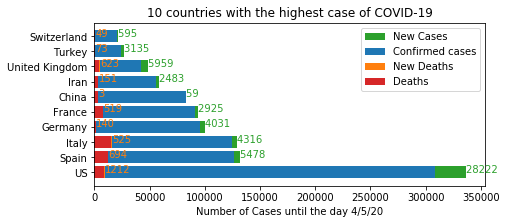

In [12]:
#plot a horizontal bar with the 10 countries with highest cases
#barPlot(CountryList,registeredCases,title)
barPlot(HighestCountries(df,numberOfcontries=10).columns,50,'10 countries with the highest case of COVID-19')

Country: Days since 50 first record; Total deaths; percentage of deaths; confimed Cases

Belgium: 31; 1447 (164 new); 7.35%; 19691 (1260 new); 
Germany: 37; 1584 (140 new); 1.58%; 100123 (4031 new); 
Netherlands: 32; 1771 (115 new); 9.86%; 17953 (1226 new); 
China: 75; 3333 (3 new); 4.04%; 82602 (59 new); 
Iran: 42; 3603 (151 new); 6.19%; 58226 (2483 new); 
United Kingdom: 34; 4943 (623 new); 10.21%; 48436 (5959 new); 
France: 38; 8093 (519 new); 8.63%; 93773 (2925 new); 
US: 42; 9619 (1212 new); 2.85%; 337072 (28222 new); 
Spain: 36; 12641 (694 new); 9.60%; 131646 (5478 new); 
Italy: 44; 15887 (525 new); 12.32%; 128948 (4316 new); 


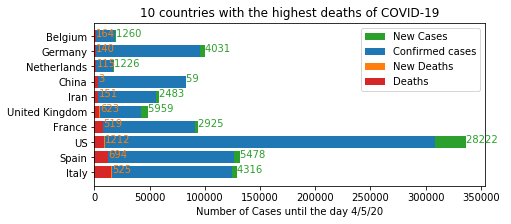

In [13]:
#plot a horizontal bar with the 10 countries with highest deaths
barPlot(HighestCountries(dfDeaths,numberOfcontries=10).columns,50,'10 countries with the highest deaths of COVID-19')

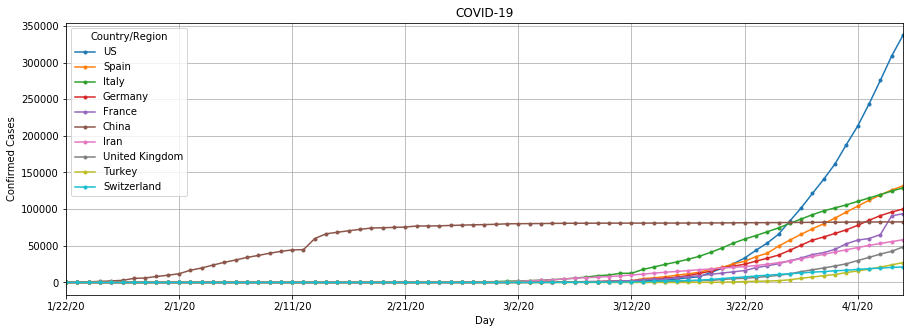

In [14]:
HighestCountries(df,10).plot(marker='.',figsize=(15,5))
plt.title('COVID-19')
plt.xlabel('Day')
plt.ylabel('Confirmed Cases')
plt.grid()
#plt.savefig('ConfirmedCasesInCalendar.png', dpi=300)

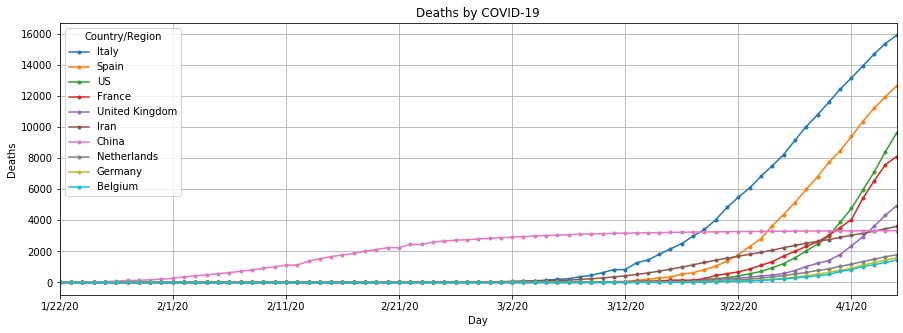

In [15]:
HighestCountries(dfDeaths,10).plot(marker='.',figsize=(15,5))
plt.title('Deaths by COVID-19')
plt.xlabel('Day')
plt.ylabel('Deaths')
plt.grid()
#plt.savefig('DeathsInCalendar.png', dpi=300)

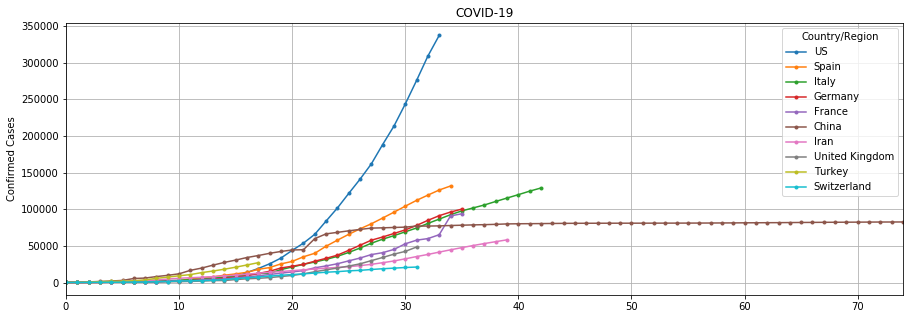

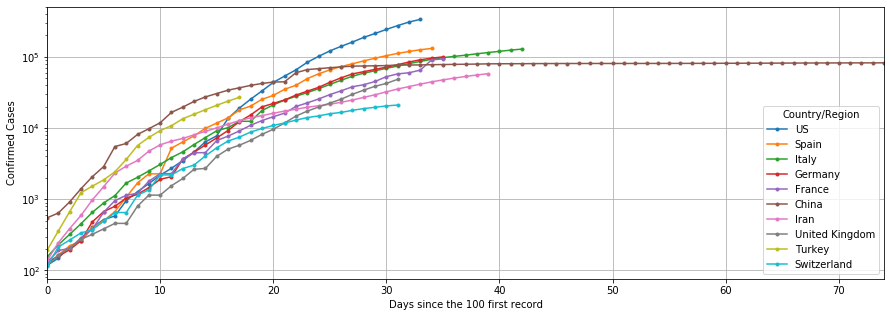

In [16]:
D=100
perDay(HighestCountries(df,10),D).plot(marker='.',figsize=(15,5))
plt.title('COVID-19')
plt.ylabel('Confirmed Cases')
plt.grid()
perDay(HighestCountries(df,10),D).plot(logy=True, marker='.',figsize=(15,5))
plt.ylabel('Confirmed Cases')
if D==0:
    plt.xlabel('Days since the first record'),
else:
    plt.xlabel('Days since the %d first record' % D)
plt.grid()
#plt.savefig('CasesVSDays.png', dpi=300)

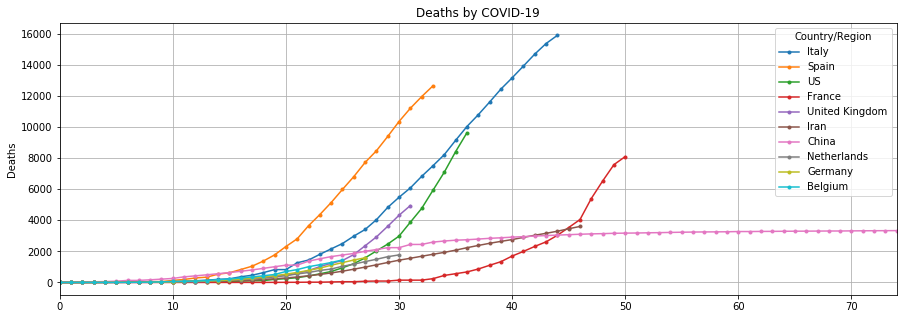

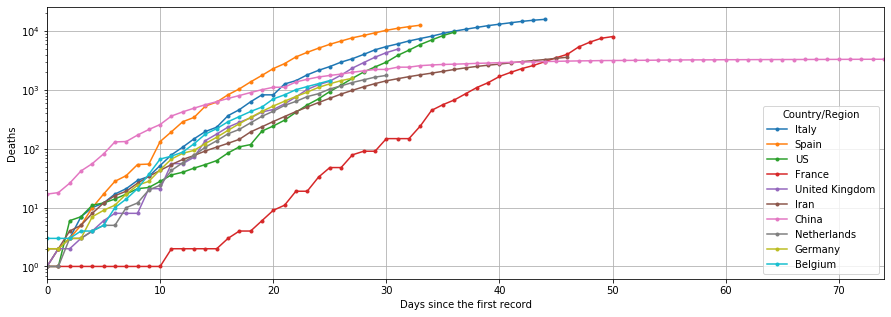

In [17]:
D=0
perDay(HighestCountries(dfDeaths,10),D).plot(marker='.',figsize=(15,5))
plt.title('Deaths by COVID-19')
plt.ylabel('Deaths')
plt.grid()
perDay(HighestCountries(dfDeaths,10),D).plot(logy=True, marker='.',figsize=(15,5))
plt.ylabel('Deaths')
if D==0:
    plt.xlabel('Days since the first record'),
else:
    plt.xlabel('Days since the %d first record' % D)
plt.grid()
#plt.savefig('DeathsVSDays.png', dpi=300)

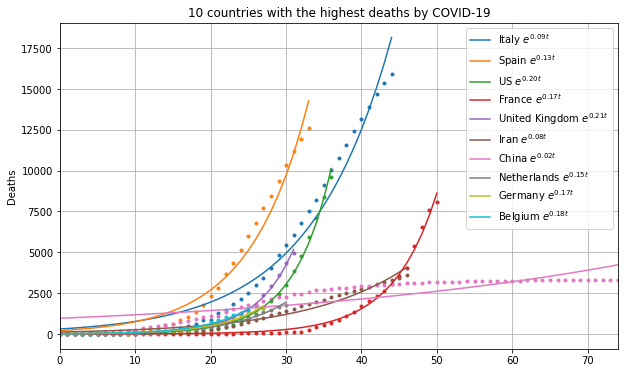

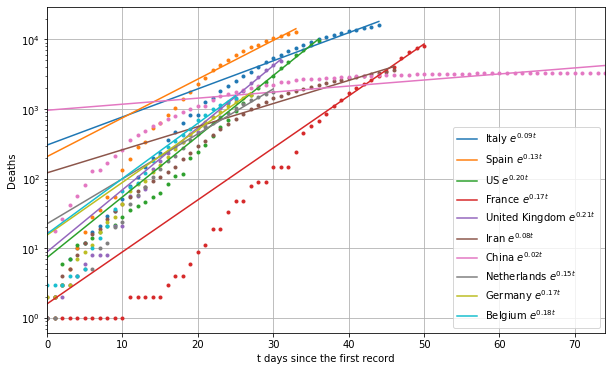

In [46]:
D=0
ax = perDay(HighestCountries(dfDeaths,10),D).plot(style='.')
ax.legend('')
fit(perDay(HighestCountries(dfDeaths,10),D)).plot(ax=ax, figsize=(10,6))
plt.title('10 countries with the highest deaths by COVID-19')
plt.ylabel('Deaths')
plt.grid()
plt.savefig('FitDeathsVSDays.png', dpi=300)

ax = perDay(HighestCountries(dfDeaths,10),D).plot(style='.')
ax.legend('', prop={'size': 18})
fit(perDay(HighestCountries(dfDeaths,10),D)).plot(ax=ax, logy=True, figsize=(10,6))
plt.ylabel('Deaths')
if D==0:
    plt.xlabel('t days since the first record'),
else:
    plt.xlabel('t days since the %d first record' % D)
plt.grid()
plt.savefig('FitDeathsVSDaysLog.png', dpi=300)
warnings.filterwarnings('ignore')